In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model, Model
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, CSVLogger
import os, numpy as np
import matplotlib.pyplot as plt
import efficientnet.tfkeras as efn 
import matplotlib as mpl
import pandas as pd

## DATA

This part of a demo covers most of the operation with a dataset generated by 

By this time the turotial doesn't provide code for a data generation process because of its relative computational complexity. Hopefully, in a future release we will add this functionality in the tutorial.

### DOWNLOAD AND UNPACK

To be discussed...

In [2]:
print(tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


In [8]:
import sys
SOURCEDIR = '../source/'
if not os.path.abspath(SOURCEDIR) in sys.path:
    sys.path.append(os.path.abspath(SOURCEDIR))

In [6]:
SOURCEDIR = '../source/'
sys.path.insert(0, os.path.abspath(os.path.abspath(SOURCEDIR)))

In [ ]:
os.environ['DATADIR']

#directory with .csv files
DATADIR = './'
MODELDIR = 'saved_weights/'

filedir = os.path.join(os.environ['DATADIR'], 'deepnano/', 'data251019/')
#directory with all necessary files including mask, dictionary and spectra files
#filedir = '/ibex/scratch/projects/c2064/data/deepnano/data_50_50/'

### STRUCTURE

Let's have a close look on how data is stored in DEEPNANO. 

Each dataset has a corresponong .csv file with all necessary information about generated samples. Each sample represents an output from FDTD simulations of a structure with a periodic boundary conditions and random shape as a mask.

In [145]:
data = pd.read_csv(DATADIR + 'toydata.csv',index_col=0)
nshapes = data.types.map(lambda x: len(x.split('-')))
names = data.index.values 
wxs = data.nx.values
wys = data.ny.values
data.sample(5)

,dz,overlap,types,nx,ny,status
D5IScnotWOyLfZrFBF48,0.1,True,rectangle-rectangle-rectangle-rectangle,100,100,test
6umOzDosv1spBALkq2Lf,0.1,True,rectangle-rectangle,100,100,val
Tgtg3uvUA5Gi1VGhNJih,0.1,True,rectangle-rectangle-rectangle,100,100,train
wbsVKlE2KtG6QXVw1SOK,0.1,False,rectangle,100,100,test
s1J5eq99HYrChUYtZa9q,0.1,True,rectangle-rectangle-rectangle,100,100,test


Each sample represents an output from FDTD simulations of a structure with a periodic boundary conditions and random shape as mask with different thickness and periods. 

To generate a "random" shapes we use an auxillary utils described in shapes.py source file with some examples of usage. In this tutorial we will mention only some key functionality of this class.

### DATA GENERATORS

To access the data in deeplearning manner, we provide two main types of data generators: online and offline defined in data.py source file. 

Typically output from FDTD simulations usually are some physical quntities of interest, such as flat transmission/reflection response for TE/TM polarized plane wave and corresponding phases. Offline generator generate this quantities from pre-simulated data. This generator is very useful on training and evaluation steps. 

Online generator generate the data itself (shapes from rendom shapes package or simulations with first principle simulator). This generator in useful for pre-training, post-training and optimization phases. 

In [2]:
from data import OnlineData, OfflineData

def imshow():
    pass

## TRAINING PROCESS

All auxillary training functions are distrubuted over 'pretrain.py', "train.py" and "posttrain.py"files in source directory (with an example of usage). Training process are usually takes several hours on a single GPU, so don't try to run it on CPU. 

### PRE-TRAINING

Even thouch the task we are trying to solve are belongs to so-called semi-supervised learning task, optical first principle simulations (FDTD) are quite a complex and an expensive computational procedure. That's why, before we tackle the main of FDTD simulation predictions, we may want to consider a simpler task on which we can pre-train part of our model (convolution base) on almost "infinite" amount of samples. Good candidate for these type of tasks could be any task which requires a model duting the solutions of this task to identify some gemetrical properties of an input shapes, such as shape type, size, position, relative distance and etc. 

For the main paper we pre-train our model on a complex task of shape detection and classification using similar to Mask-RCNN approach. The training process with this approach though is a quite an effective, but is a very computationally expensive as well. 

So in this demo we put much simpler approach of pre-training ALFRED prediction part with autoencoders. The encoder is encoding a high-dimensional image representation to a low-dimensional vector, which size are specified by the parameter code_size.

In [3]:
from tensorflow import keras
from tensorflow.keras import layers as L
import efficientnet.tfkeras as efn
from classification_models.keras import Classifiers
from tensorflow.keras.applications import VGG16, VGG19
ResNet18, preprocess_input = Classifiers.get('resnet18')

from pretrain import decoder_100x100, build_deep_autoencoder

K.clear_session()

def conv_base(input_shape=[100,100,1], model='effnet'):
    if model == 'effnet':
        conv_base = efn.EfficientNetB0(weights=None, input_shape=input_shape, include_top=False,
                                       pooling='avg')  # or weights='noisy-student'
    elif model == 'resnet':
        conv_base = ResNet18(input_shape=input_shape, include_top=False)
    else:
        raise ValueError('Unrecognized model!')
        
    return conv_base

In [128]:
input_shape=[100,100,1]
conv = conv_base(input_shape,model='effnet')
code_size=100
encoder, decoder = build_deep_autoencoder(conv,code_size)

inp = L.Input([100,100,1])
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer="adamax", loss='binary_crossentropy')

Fot this task we don't need a simulated spectra, so we can use online shape generators.

In [7]:
#%load_ext autoreload
#%autoreload 2
from data import OnlineData as DataSet
data = DataSet(input_shapes=[100])
batch_size=64
X_train=data.geometry_label_generator(batch_size,types=['rectangle','circle','ellipse'], min_size=15, max_shapes=3,input_mode=True)
X_test=data.geometry_label_generator(batch_size,types=['rectangle','circle','ellipse'], min_size=15, max_shapes=3,input_mode=True)

In [8]:
data_dir = os.environ['DATADIR'] + 'deepnano/'
tb = TensorBoard(log_dir=os.path.join(data_dir, 'logs', 'autotest'))

steps_per_epoch = 100
validation_steps = 10
autoencoder.fit_generator(
    generator=X_train,
    steps_per_epoch=steps_per_epoch,
    epochs=100,
    verbose=1,
    callbacks=[tb],
    validation_data=X_test,
    validation_steps=validation_steps)

NameError: name 'autoencoder' is not defined

Below you can have a look on a set random examples of encoding capabilities of our framework

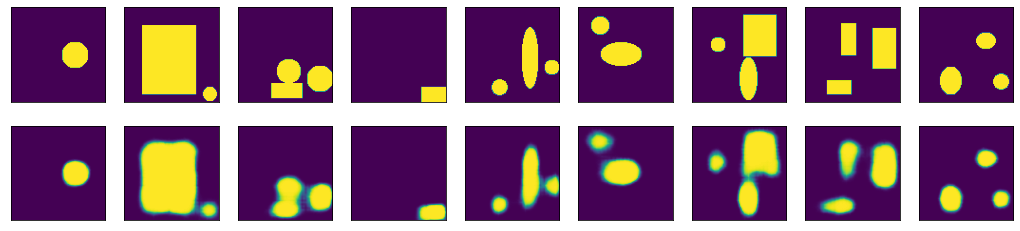

In [121]:
i=iter(X_test)
X, _= next(i)
decoded_imgs = autoencoder.predict(X)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(np.squeeze(X[i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(np.squeeze(decoded_imgs[i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### TRAINING



The training utilities are contained in train.py file. The main function of this model is a train loop itself. For this training task we need use an offline data generator.

In [159]:
from data import OfflineData as DataSet
from scipy.integrate import trapz
data = DataSet(npoints=80, datafile=['rect_same_period_100_100'], input_shape=[100,100])

In [ ]:
from train import train

model=='effnet'
input_shape = [100, 100]

train(model,
      one_thickness=True,
      load_to_memory=False,
      thick_idx=int(thick_idx),
      npoints=80,
      batch_size=64,
      datafile=['toy_data'],
      random_orientation=True,
      random_translation=False,
      input_shape=input_shape,
      pad=False,
      resized=True
      )

## PREDICTOR

ALFRED consists of two main units: predictor unit (shown as a pink cell) which represents and optimizer unit (shown as bees), which using the predictions from deepnano performs a search in a multidimensional search space. 

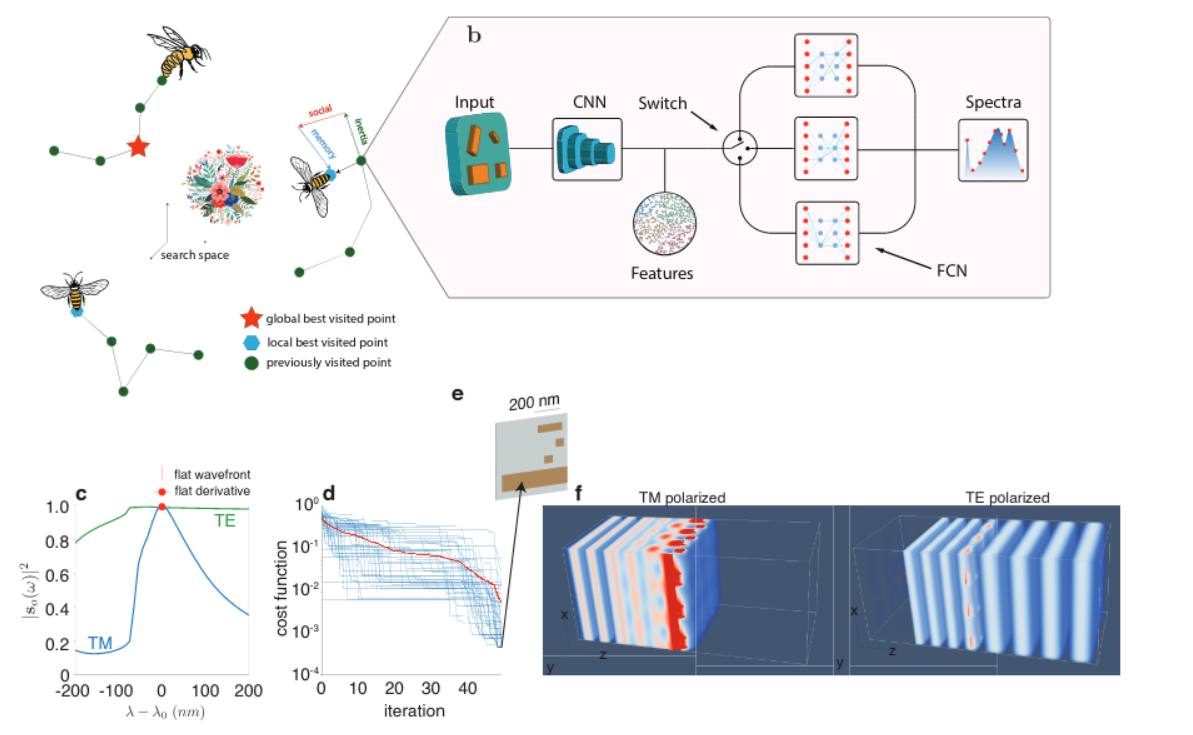

Once the model was trained we can use it to generate a fast FDTD predictions. To standartize predictor interface, predictor.py file 

In [160]:
from predictor import NNSimulator
predictor = NNSimulator(saved_model='saved_weights/best_effnet2.hdf5')

To evaluate performance let's load whole test dataset and compare the predictions 

In [161]:
data = DataSet(npoints=80, datafile=['rect_same_period_100_100'], input_shape=[100,100])
indices, X, y = data.get_all_sequences_in_memory('test',with_indices=True)

Loading 4000 samples into memory for testing.


Below you can see a summary info with some random examples from test dataset. For our applications we empirically define a threshold at 0.005 MSE. So as you can see more >98% of the predictions satisfy this condition.

125/125 [==============================] - 2s 13ms/step - loss: 8.8984e-04
Average MSE 5.5615192200429185e-11
Predictions with MSE lower than a treshhold (>0.005) 400000.0 %


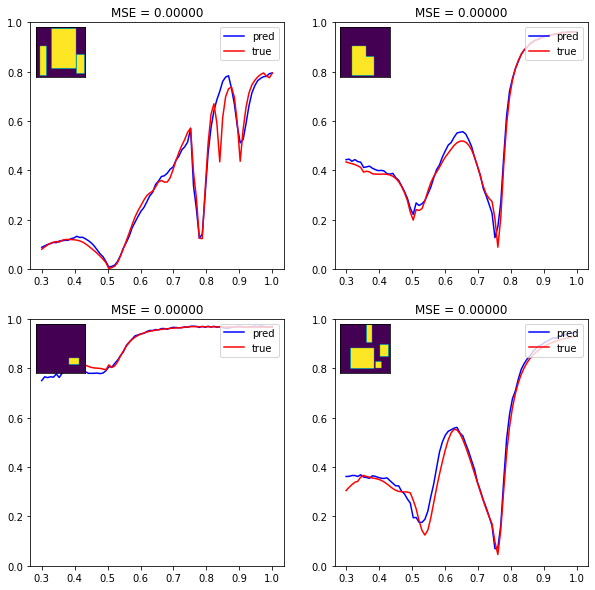

CPU times: user 2.78 s, sys: 494 ms, total: 3.27 s
Wall time: 3.75 s


In [163]:
%%time
predictor.eval(X, y)
predictor.show_summary()

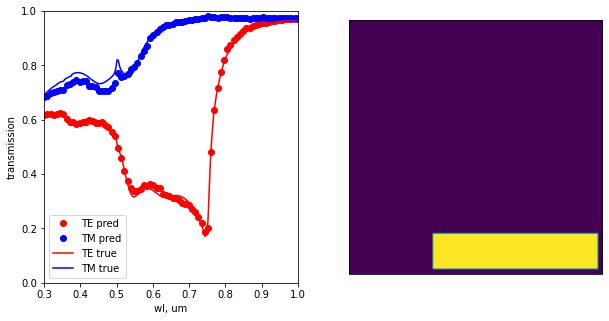

In [176]:
def get_spectra(token):
    spectra = np.fromfile(filedir+token+'-spectra.bin',dtype=float).reshape(-1,5)
    wl, te, tm = spectra[:,0], spectra[:,1], spectra[:,2]
    return np.stack([wl,te,tm],axis=-1)

idx = np.random.randint(len(indices))
y = get_spectra(indices[idx])
predictor.show_mask_and_prediction(X,y=y,idx=idx,channel=0)

### POST-TRAINING 

to be discussed...

## OPTIMIZER

The optimizer part described in original paper are based on a parallel realization of a Particle Swarm Optimization algorithm (PSO). Swarm parallel optimizer that searches the multidimensional space of solutions with an array of tentative geometries that use acooperative scheme based on self and social interactions. 

1. As a first example we show how to use ALFRED to find a high-efficient optical polarizer. In this examples for a demonstrational purposes we use a simpler cost function and working only with transmission. 

In original paper we demonstrated ALFRED functionality on a set of common inverse-design task. 

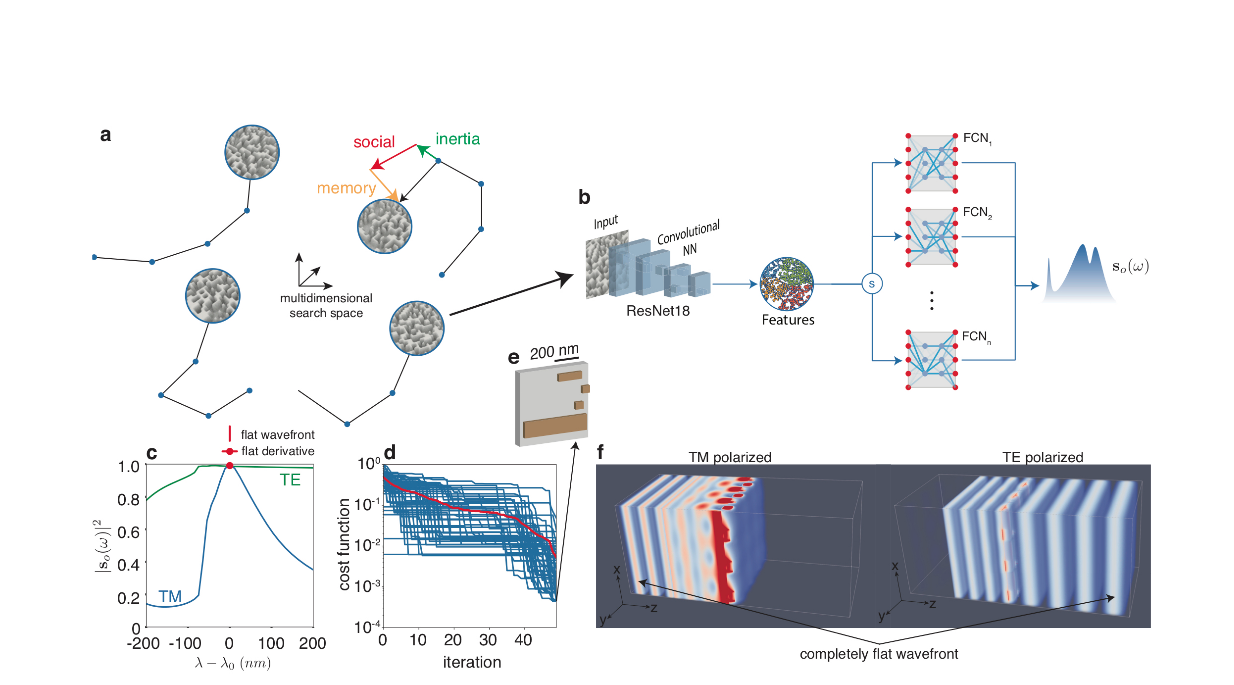

In [3]:
from predictor import NNSimulator
from data import OfflineData as DataSet
predictor = NNSimulator(saved_model='saved_weights/50x50-8_effnet.hdf5')

In [112]:
data = DataSet(npoints=80, datafile=['data_rect_50_50'], input_shape=[100,100],thick_idx=8)
indices, X, y = data.get_all_sequences_in_memory('test',with_indices=True,pad=False,resized=True)

Loading 3995 samples into memory for testing.


125/125 [==============================] - 2s 13ms/step - loss: 9.2583e-04
Average MSE 5.800922908631046e-11
Predictions with MSE lower than a treshhold (>0.005) 399500.0 %


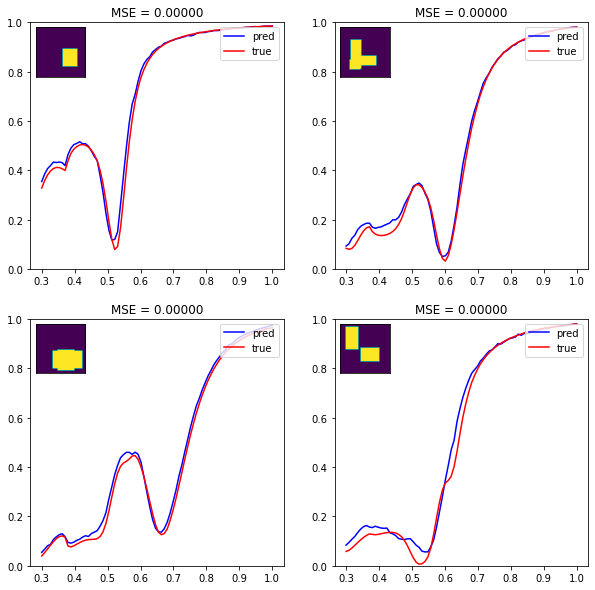

CPU times: user 2.14 s, sys: 121 ms, total: 2.26 s
Wall time: 3.66 s


In [114]:
%%time
predictor.eval(X, y)
predictor.show_summary()

In [246]:
from predictor import NNSimulator
K.clear_session()
predictor = NNSimulator(saved_model=['saved_weights/50x50-8_effnet.hdf5',
                                     'saved_weights/50x50-6_effnet.hdf5',
                                     'saved_weights/50x50-2_effnet.hdf5',
                                     'saved_weights/50x50-5_effnet.hdf5',
                                     'saved_weights/50x50-4_effnet.hdf5'])
#predictor = NNSimulator(saved_model='saved_weights/best_effnet2.hdf5')
#predictor.model.summary()

In [248]:
from data import OnlineData as DataSet
batch_size = 10
nInputs = predictor.n_inputs
data = DataSet(input_shapes=[100]*nInputs)
X_gen=data.geometry_label_generator(batch_size,types=['rectangle'], min_size=10, max_shapes=3)
i = iter(X_gen)
inputs, labels = next(i)

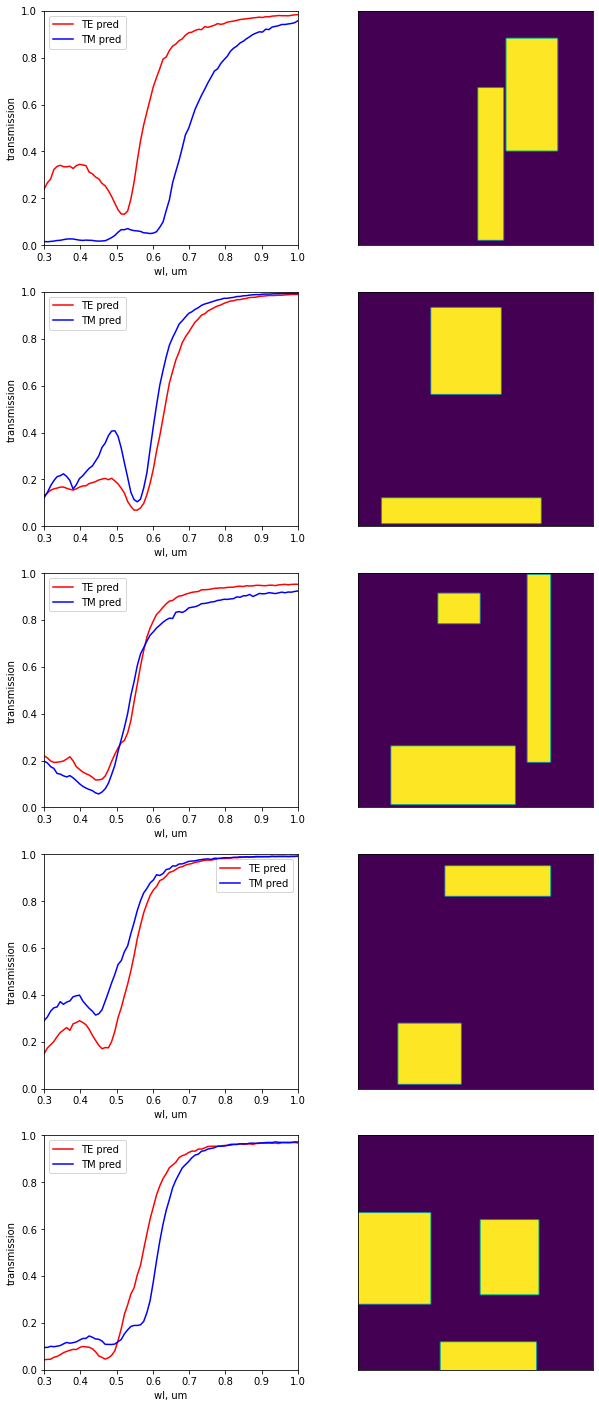

In [250]:
inputs, labels = next(i)
predictor.show_mask_and_prediction(inputs,idx=4)

In [235]:
te, tm = predictor.predict_te_tm(inputs)
te.__len__()

3

In [49]:
axes[:,1]

array([<matplotlib.axes._subplots.AxesSubplot object at 0x2b8932a9dfd0>],
      dtype=object)

In [657]:
rotate?

In [ ]:
rotate(inputs[0][0],90,preserve_range=True).astype

In [ ]:
rotate(inputs[0][0],90,preserve_range=True).astype

In [585]:
from skimage.transform import AffineTransform, warp, rotate
rotate?

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2ba9e2104d30>)

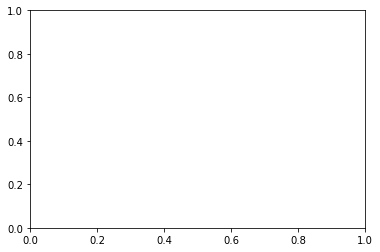

In [343]:
plt.subplots(1,1)

In [281]:
predictor.predict_te_tm(inputs)

[autoreload of predictor failed: Traceback (most recent call last):
  File "/home/makam0a/anaconda3/envs/tensorflow/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/makam0a/anaconda3/envs/tensorflow/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/home/makam0a/anaconda3/envs/tensorflow/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/makam0a/anaconda3/envs/tensorflow/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/home/makam0a/anaconda3/envs/tensorflow/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/makam0a/anaconda3/envs/tensorflow/lib/python3.8/site-packages/IPython/e

AssertionError: in user code:

    /home/makam0a/anaconda3/envs/tensorflow/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1147 predict_function  *
        outputs = self.distribute_strategy.run(
    /home/makam0a/anaconda3/envs/tensorflow/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/makam0a/anaconda3/envs/tensorflow/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/makam0a/anaconda3/envs/tensorflow/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/makam0a/anaconda3/envs/tensorflow/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1122 predict_step  **
        return self(x, training=False)
    /home/makam0a/anaconda3/envs/tensorflow/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:927 __call__
        outputs = call_fn(cast_inputs, *args, **kwargs)
    /home/makam0a/anaconda3/envs/tensorflow/lib/python3.8/site-packages/tensorflow/python/keras/engine/network.py:717 call
        return self._run_internal_graph(
    /home/makam0a/anaconda3/envs/tensorflow/lib/python3.8/site-packages/tensorflow/python/keras/engine/network.py:899 _run_internal_graph
        assert str(id(x)) in tensor_dict, 'Could not compute output ' + str(x)

    AssertionError: Could not compute output Tensor("model_1_5/Identity:0", shape=(None, 80), dtype=float32)


In [283]:
d = {'a':1,'b':2}
d.get('y')

In [185]:
inputs =np.zeros([1,100,100,1])
predictor.predict_te_tm(inputs)

([array([[0.9027895 , 0.9111146 , 0.92072403, 0.9227489 , 0.9259511 ,
          0.9170492 , 0.93392646, 0.92691606, 0.92573315, 0.93926114,
          0.9326186 , 0.92444235, 0.92727506, 0.94063884, 0.92758596,
          0.93290675, 0.94091654, 0.9361383 , 0.9355932 , 0.9503433 ,
          0.9513837 , 0.9519269 , 0.9611475 , 0.95940393, 0.96715254,
          0.9784506 , 0.97949684, 0.98651206, 0.9898067 , 0.9912833 ,
          0.9909542 , 0.99116427, 0.9919159 , 0.9821743 , 0.98066074,
          0.97756106, 0.9688122 , 0.96735865, 0.96701473, 0.9674191 ,
          0.9654247 , 0.96731913, 0.97188777, 0.9759591 , 0.9665474 ,
          0.9672468 , 0.9688992 , 0.9662764 , 0.9740676 , 0.9596789 ,
          0.9617141 , 0.9606748 , 0.9545513 , 0.9484621 , 0.9544933 ,
          0.95743984, 0.9566543 , 0.9692215 , 0.95229137, 0.94649637,
          0.9514186 , 0.94646645, 0.9638732 , 0.9611095 , 0.95764816,
          0.9589421 , 0.96317047, 0.9626627 , 0.9511796 , 0.96616113,
          0.95487887

In [17]:
def cost(te,tm,central=800,dw=100):
    wl = np.linspace(300,1000,len(te))
    mask = (wl<(central+dw/2)) * (wl>(central-dw/2))
    return -np.abs(trapz(te[mask])-trapz(tm[mask]))

/home/makam0a/shapes/shape_generators.py:26: UserWarning: Could not fit any shapes to image, consider reducing the minimum dimension
  image, labels = random_shapes(mesh.shape, min_shapes=min_shapes, shape='rectangle', max_shapes=max_shapes, multichannel=multichannel, intensity_range=intensity_range, **kargs)


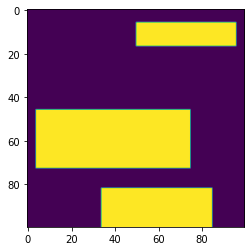

In [117]:
from data import OnlineData as DataSet
from IPython.display import clear_output
from shapes import generate_random_shapes, Canvas, ShapelyShape as Shape
from preprocess import from_labels_to_x, from_x_to_labels, from_labels_to_image, from_x_to_image
from scipy.integrate import trapz
data = DataSet(input_shapes=[100])
batch_size=1000
X_gen=data.geometry_label_generator(batch_size,types=['rectangle'], min_size=10, max_shapes=3)
i = iter(X_gen)
X, labels = next(i)
idx = np.random.randint(len(labels))
x = from_labels_to_x(labels[idx])
l = from_x_to_labels(x)
plt.imshow(X[idx])
plt.show()

In [267]:
input_shape = [100,100]

#number of parameters for rectangle
nparam = 4
#boundaries (with respect to input_shape)
wb=np.array([0.0,0.95])
lr = 0.1
central=0.6

n_inputs = predictor.n_inputs
n_outputs = predictor.n_outputs
pooling = np.min

#predictor = NNSimulator(saved_model='saved_weights/best_effnet2.hdf5')

def cost(te,tm,central=central*1e3,dw=100):
    wl = np.linspace(300,1000,len(te))
    mask = (wl<(central+dw/2)) * (wl>(central-dw/2))
    return -np.abs(trapz(te[mask])-trapz(tm[mask]))

############## INIT SINGLE PARTICLE FUNCTION                                                                                                                                                                                           
def init(x,v):
    # Center values;                                                                                                                                                                                                                   
    #init dz
    N = x.__len__() // nparam
    for i in range(N):
        xy_c = np.random.random(2)
        wx, wy = np.random.random(2) * (wb[1]-wb[0]) + wb[0]
        x[nparam*i:nparam*i+nparam] = xy_c[0],xy_c[1],wx,wy
        v[nparam*i:nparam*i+nparam] = (2*np.random.random(4)-1) * wb[1] * lr


def fun(X,predictor=predictor.predict_te_tm, input_shape=input_shape, cost=cost, pooling=pooling):
    X = np.array(X)
    batch = True
    if len(X.shape)<2:
        batch = False
        #add batch dimension
        X = np.expand_dims(X,axis=0)
    batch_size = X.shape[0]
    inputs = []
    for i in range(n_inputs):
        X_image = np.zeros([batch_size,*input_shape,1],dtype=np.int32)
        for i,x in enumerate(X):
            X_image[i] = np.expand_dims(from_x_to_image(x,input_shape),axis=-1)
        inputs.append(X_image)
    te_outputs, tm_outputs = predictor(inputs)
    fitnesses = []
    for i in range(n_outputs):
        te, tm = te_outputs[i], tm_outputs[i]
        fitnesses.append([cost(te,tm) for te, tm in zip(te, tm)])
    fitnesses = np.array(fitnesses).reshape(batch_size,n_outputs,-1)
    fitnesses= pooling(fitnesses,axis=1)
    if not batch:
        # if input is a single sample -> output also single
        fitnesses = fitnesses[0]
    return fitnesses

def bond(x):
    N = x.__len__() // nparam
    for i in range(N):
        xy_c = np.array(x[nparam*i:nparam*i+2])
        xy_c = np.mod(xy_c,1)
        w = np.array(x[nparam*i+2:nparam*i+4])
        w = np.minimum(w,wb[1])
        w = np.maximum(w,wb[0])
        xy_c=np.minimum(1-w/2,xy_c)
        xy_c=np.maximum(w/2,xy_c)
        x[nparam*i:nparam*i+nparam] = xy_c[0],xy_c[1],w[0],w[1]
        
# init the problem
nshapes = 2
opts={
    'dim':nshapes*nparam,
    'rng':1000,#839,#1734, #1625
    'swarmSize':30,#25
    'maxIter':100,
    'inertiaR':np.array([0.3,1.3]),
    'minNfrac':0.25,
    'cognitive':1.49,
    'social':1.49,#1.8,#1.49,
    'fun':fun,
    'boundary':bond,
    'init_part':init,
    }

from pso import pswarm

class optimizer(pswarm):
    def __init__(self,opts):
        self.opts = opts
        self.state=np.ones([opts['swarmSize'],opts['maxIter']])
        pswarm.__init__(self,opts)
    
    def update_stats(self):
        pswarm.update_stats(self)
        for i in range(self.swarmSize):
            self.state[i,self.currit] = self.swarm[i].fbest
    
    def show(self):
        clear_output()
        pswarm.show(self)
        plt.figure()
        for particle in self.state:
            particle = particle[particle<0]
            plt.plot(particle)
        plt.xlabel('current iteration')
        plt.ylabel('cost')
        plt.show()
        Xbest = np.expand_dims(from_x_to_image(self.gxbest,input_shape),axis=0)
        costs = fun(self.gxbest,pooling=(lambda x, axis=-1: x))
        i = np.argmin(costs)
        print(i)
        fig, axes = plt.subplots(1,2,figsize=[10,5])
        predictor.show_mask_and_prediction([Xbest]*n_inputs,channel=i,axes=axes)
        axes[0].set_xlim(central-0.2,central+0.2)
        axes[0].axvspan(central-0.05, central+0.05, alpha=0.2, color='green')
        fig.show()

current iteration = 3
current fbest = [-8.177733]


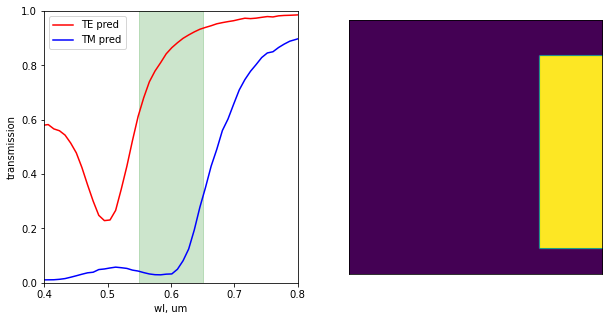

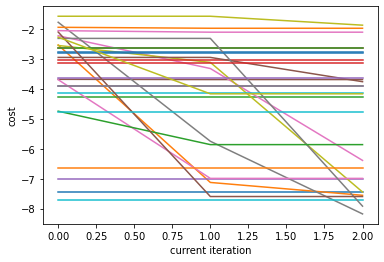

1


KeyboardInterrupt: 

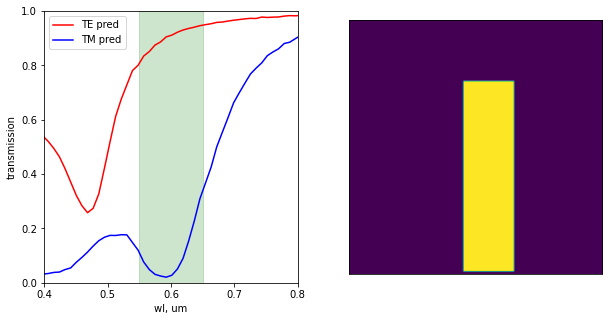

In [268]:
polarizer_swarm = optimizer(opts)

current iteration = 5
current fbest = -7.6671


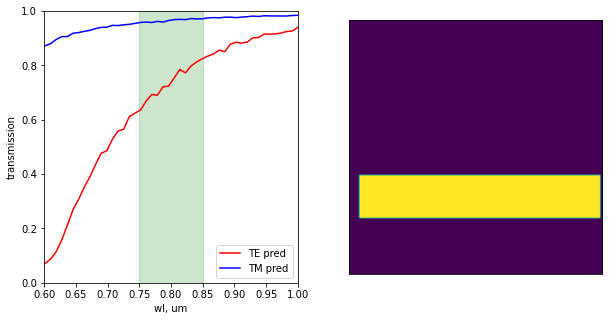

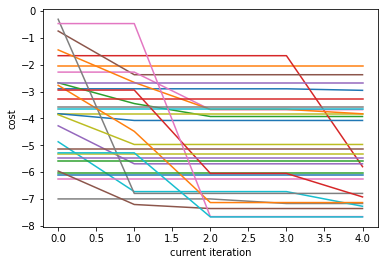

/ibex/scratch/projects/c2064/projects/deepnano/pso.py:156: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  subset[msk]=subset[msk]+1


KeyboardInterrupt: 

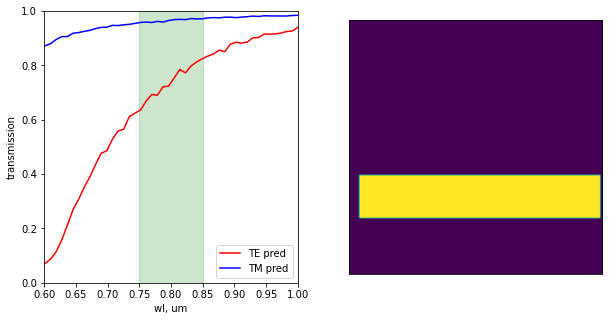

In [260]:
central=0.8
polarizer_swarm = optimizer(opts)

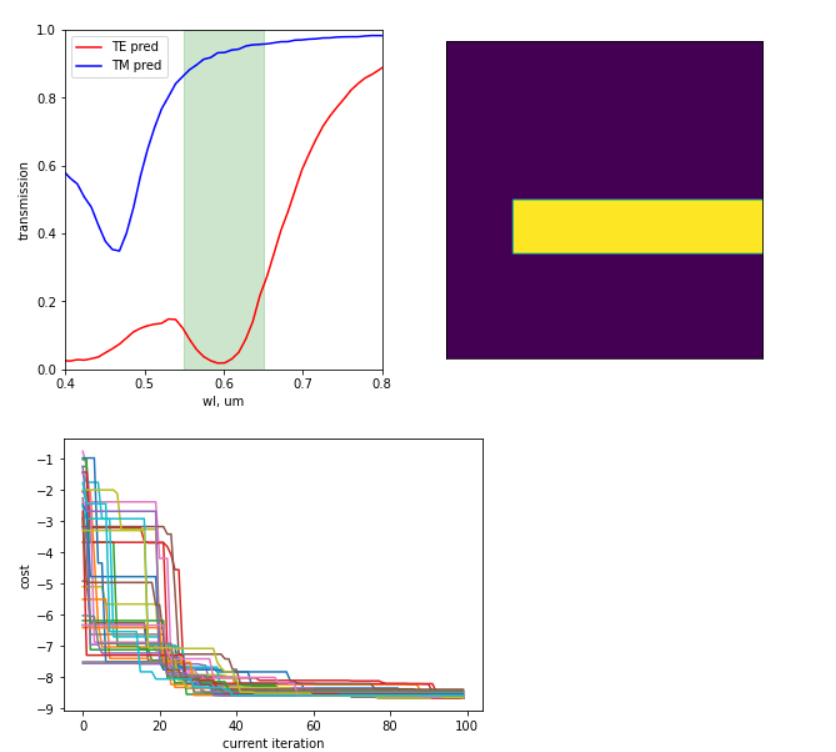

2. Second example we demonstrate here is an optimizaton for so-called two sub-pixel color-display samples. 

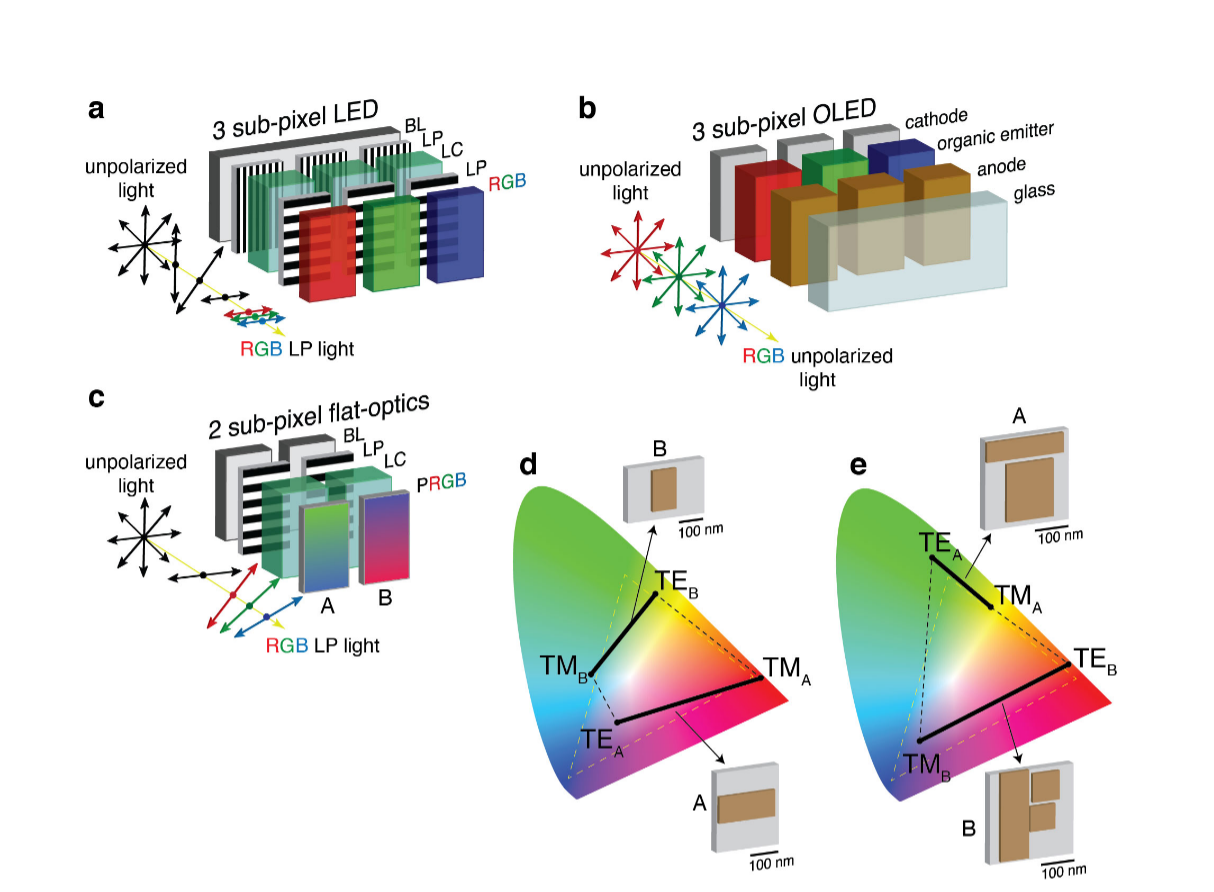

Two sub-pixel flat optics color display: idea and design. (a-b) Basic working principle of current LCD/OLED color technologies based on three red, green and blue (RGB) sub-pixel color transmission units. (c) Proposed flat-optics technology based on two polarization controlled sub-pixels A and B. (d-e) ALFRED designs of A and B (3D brown boxes with gray unit cell) with chromaticity gamuts contained in (d) and exceeding (e) the standard RGB colorspace (dashed yellow line). In panels (d)-(e), the chromaticity obtained when the input light varies between $TE_x$ and $TM_x$ polarizations for samples $A,B$ is indicated as a solid black thick line, while the total gamut obtained by mixing the two sub-pixels is the four point rhomboid delimited by the dashed black lines

In [298]:
from cost_functions import color_cost
from colors import color
from colour.plotting import plot_chromaticity_diagram_CIE1931

def get_color_xy(te,tm,xmin=300,xmax=1000):
    wl=np.linspace(xmin,xmax,len(te))
    te = np.stack([wl,te],axis = 1)
    tm = np.stack([wl,tm],axis = 1)
    te_xy = color(te).xy
    tm_xy = color(tm).xy
    return te_xy, tm_xy

In [285]:
from data import OnlineData as DataSet
batch_size = 10
nInputs = predictor.n_inputs
data = DataSet(input_shapes=[100]*nInputs)
X_gen=data.geometry_label_generator(batch_size,types=['rectangle'], min_size=10, max_shapes=3)
i = iter(X_gen)
inputs, labels = next(i)

In [316]:
input_shape = [100,100]

#number of parameters for rectangle
nparam = 4
#boundaries (with respect to input_shape)
wb=np.array([0.0,0.95])
lr = 0.1

def cost_multiple_outputs(output_1,output_2,cost):
    output_te_xy, output_tm_xy = output_1.reshape(n_outputs,2,2).transpose([1,0,2])
    output_te_xy2, output_tm_xy2 = output_2.reshape(n_outputs,2,2).transpose([1,0,2])
    fitnesses = []
    for te_xy, tm_xy in zip(output_te_xy, output_tm_xy):
        for te_xy2, tm_xy2 in zip(output_te_xy2, output_tm_xy2):
            fitnesses.append(-cost(te_xy,tm_xy,te_xy2,tm_xy2))
    fitnesses = np.array(fitnesses)
    idx = np.argmin(fitnesses)
    i,j = divmod(idx,n_outputs)
    return np.array([[output_te_xy[i],output_tm_xy[i]],
                     [output_te_xy2[j],output_tm_xy2[j]]]),fitnesses.reshape(n_outputs,n_outputs)

#predictor = NNSimulator(saved_model='saved_weights/best_effnet2.hdf5')

############## INIT SINGLE PARTICLE FUNCTION
#In case of optimizing colorspace volume with two metasurfaces, we need to run 2 simulations
def init2(x,v):
    # Center values;                                                                                                                                                                                                                   
    #init dz
    tmpx = x.reshape(-1,2)
    tmpv = v.reshape(-1,2)
    init(tmpx[:,0],tmpv[:,0])
    init(tmpx[:,1],tmpv[:,1])
    x[:len(x)//2]=tmpx[:,0]
    x[len(x)//2:]=tmpx[:,1]
    v[:len(x)//2]=tmpv[:,0]
    v[len(x)//2:]=tmpv[:,1]

#main function
def fun2(X,cost=color_cost,argmin=False,**kargs):
    X = X.reshape(x.shape[:-1] + (-1,2))
    #different outputs
    output_1 = fun(X[:,0],cost=get_color_xy,pooling=(lambda x, axis=-1: x))
    output_2 = fun(X[:,1],cost=get_color_xy,pooling=(lambda x, axis=-1: x))
    cie, fitnesses = cost_multiple_outputs(output_1,output_2,color_cost)
    if argmin:
        return divmod(fitnesses.argmin(),n_outputs), fitnesses.min(), cie
    return fitnesses.min()
    

def bond2(x):
    tmpx = x.reshape(-1,2)
    bond(tmpx[:,0])
    bond(tmpx[:,1])
    x[:len(x)//2]=tmpx[:,0]
    x[len(x)//2:]=tmpx[:,1]
        
# init the problem
nshapes = 2
opts={
    'dim':2*nshapes*nparam,
    'rng':1000,#839,#1734, #1625
    'swarmSize':200,#25
    'maxIter':500,
    'inertiaR':np.array([0.3,1.3]),
    'minNfrac':0.25,
    'cognitive':1.49,
    'social':3,#1.8,#1.49,
    'fun':fun2,
    'boundary':bond2,
    'init_part':init2,
    }

from pso import pswarm

class optimizer(pswarm):
    def __init__(self,opts):
        self.opts = opts
        self.state=np.ones([opts['swarmSize'],opts['maxIter']])
        pswarm.__init__(self,opts)
    
    def update_stats(self):
        pswarm.update_stats(self)
        for i in range(self.swarmSize):
            self.state[i,self.currit] = self.swarm[i].fbest
    
    def show(self):
        clear_output()
        pswarm.show(self)
        idx, _, (cie_1,cie_2) = fun2(self.gxbest,argmin=True)
        print(idx)
        plt.figure()
        for particle in self.state:
            particle = particle[particle<0]
            plt.plot(particle)
        plt.xlabel('current iteration')
        plt.ylabel('cost')
        plt.show()
        gxbest=np.array(self.gxbest).reshape(self.gxbest.shape[:-1] + (-1,2))
        Xbest0 = from_x_to_image(gxbest[:,0],input_shape)
        Xbest1 = from_x_to_image(gxbest[:,1],input_shape)
        plt.figure(figsize=[10,5])
        plt.subplot(121)
        plt.imshow(Xbest0)
        plt.subplot(122)
        plt.imshow(Xbest1)
        plt.show()
        plot_chromaticity_diagram_CIE1931(standalone=False)
        plt.plot(*list(zip(cie_1[0],cie_1[1])),'r')
        plt.plot(*list(zip(cie_2[0],cie_2[1])),'b')
        plt.show()    
    

current iteration = 40
current fbest = -0.0429894033885
(1, 1)


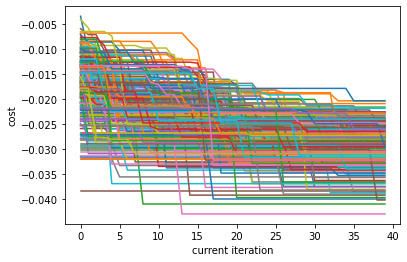

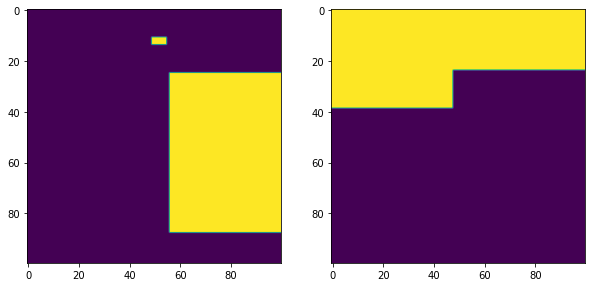

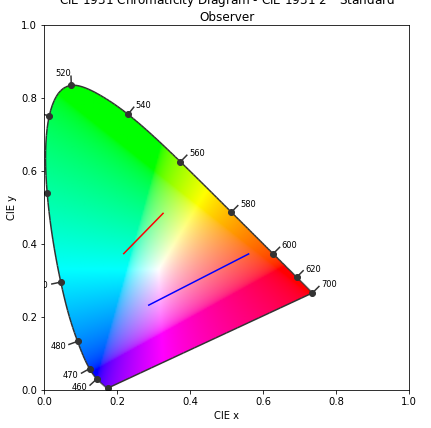

In [ ]:
color_swarm = optimizer(opts)